# piston example with Gauss-Legendre collocation

lumped moving mass + two lumped compartments (ideal gas of fixed mass)  
state-space
$
\begin{bmatrix}
    p & s_1 & v_1 & s_2 & v_2
\end{bmatrix}^\mathrm{T}
\: \in \:
\mathcal{X} \subset \mathbb{R}^5
$

When joining the piston and the two compartments
a constraint between the state variables is introduced, namely
$v_1 + v_2 = A \left( l - w \right)$.

In piston_animation.ipynb
this has been eliminated, thereby transforming the DAE system into an ODE system.
This lead to the state space
$
\begin{bmatrix}
    q & p & s_1 & s_2
\end{bmatrix}^\mathrm{T}
\: \in \:
\mathcal{X} \subset \mathbb{R}^4
$.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as anim

import sympy
sympy.init_printing()

from IPython.display import display

import numpy

import sys
sys.path.insert(0, './code')

from gauss_legendre import gauss_legendre
from symbolic import eval_expr
from evaluate_functional import evaluate_functional
import ideal_gas_lumped

### macroscopic state

In [2]:
p = sympy.Symbol('p')
s_1 = sympy.Symbol('s_1')
v_1 = sympy.Symbol('v_1')
s_2 = sympy.Symbol('s_2')
v_2 = sympy.Symbol('v_2')

x = [p, s_1, v_1, s_2, v_2]
x

### parameters

In [3]:
l = sympy.Symbol('l')
r = sympy.Symbol('r')
w = sympy.Symbol('w')
A = sympy.Symbol('A')

m_Al = sympy.Symbol('m_Al')
m_Cu = sympy.Symbol('m_Cu')
m = sympy.Symbol('m')

κ_Al = sympy.Symbol('κ_Al')
κ_Cu = sympy.Symbol('κ_Cu')
α = sympy.Symbol('α')

d = sympy.Symbol('d')

params = {
    # length of cylinder (m)
    l: 0.1,
    
    # radius of cylinder / piston (m)
    r: 0.05,

    # length of piston (m)
    w: 0.006,
    
    # cross-sectional area of piston (m**2) 
    A: r**2 * sympy.pi,

    # density of piston material (kg/m**3)
    m_Al: 2700.0,
    m_Cu: 8960.0,
    
    # mass of piston (kg)
    m: m_Cu * A * w,

    # thermal conductivity piston material (W/(m*K))
    κ_Al: 237.0,
    κ_Cu: 401.0,
    
    # thermal conduction coefficient through piston (W/K)
    α: κ_Cu * A / w,
    
    # friction coefficient between piston and cylinder (N*s/m)
    d: 1.0,
}

params = {**params, **ideal_gas_lumped.params}

### functionals

In [4]:
functionals = {}

υ = sympy.Symbol('υ')
functionals[υ] = p / m

U_1 = sympy.Symbol('U_1') # internal energy
m_1 = sympy.Symbol('m_1') # fixed mass (kg)
θ_1 = sympy.Symbol('θ_1') # temperature (K)
π_1 = sympy.Symbol('π_1') # pressure (Pa)
ideal_gas_lumped.add_functionals(functionals, U=U_1, s=s_1, v=v_1, m=m_1, m_a=ideal_gas_lumped.m_Ar, θ=θ_1, π=π_1)

U_2 = sympy.Symbol('U_2')
m_2 = sympy.Symbol('m_2')
θ_2 = sympy.Symbol('θ_2')
π_2 = sympy.Symbol('π_2')
ideal_gas_lumped.add_functionals(functionals, U=U_2, s=s_2, v=v_2, m=m_2, m_a=ideal_gas_lumped.m_Ar, θ=θ_2, π=π_2)

q = sympy.Symbol('q')
functionals[q] = v_1/A + w/2
q_2 = sympy.Symbol('q_2')
functionals[q_2] = l - v_2/A - w/2

E = sympy.Symbol('E') # total energy (J)
functionals[E] = sympy.Rational(1,2) * p**2 / m + U_1 + U_2

S = sympy.Symbol('S')
functionals[S] = s_1 + s_2

In [5]:
eval_expr(S, functionals)

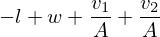

In [6]:
eval_expr(q - q_2, functionals) # should be zero

constraint
$v_1 + v_2 = A \left( l - w \right)$

### initial conditions

determine $m_1$, $m_2$ and $s_1(0)$, $s_2(0)$

In [7]:
# wanted conditions
v_10 = float(eval_expr((A*l - A*w) / 2, params=params))
v_20 = v_10

θ_10 = 273.15 + 25.0
π_10 = 1.5 * 1e5

θ_20 = 273.15 + 20.0
π_20 = 1.0 * 1e5

In [8]:
import ideal_gas
from scipy.optimize import fsolve

In [9]:
n_10 = fsolve(lambda n : ideal_gas.S_π(ideal_gas.U2(θ_10, n), v_10, n) - π_10, x0=2e22)[0]
s_10 = ideal_gas.S(ideal_gas.U2(θ_10, n_10), v_10, n_10)
# relative to Standard conditions for Temperature and Pressure (STP)
print(f"n = {n_10}")
print(f"s = {s_10}")
print(f"θ = {ideal_gas.U_θ(s_10, v_10, n_10) - 273.15} °C")
print(f"π = {ideal_gas.U_π(s_10, v_10, n_10) * 1e-5} bar")
print(f"u = {ideal_gas.U(s_10, v_10, n_10)}")

n = 1.345119603317771e+22
s = 3.3828942208847232
θ = 25.00000000000159 °C
π = 1.500000000000008 bar
u = 83.05585577928


In [10]:
n_20 = fsolve(lambda n : ideal_gas.S_π(ideal_gas.U2(θ_20, n), v_20, n) - π_20, x0=2e22)[0]
s_20 = ideal_gas.S(ideal_gas.U2(θ_20, n_20), v_20, n_20)
print(f"n = {n_20}")
print(f"s = {s_20}")
print(f"θ = {ideal_gas.U_θ(s_20, v_20, n_20) - 273.15} °C")
print(f"π = {ideal_gas.U_π(s_20, v_20, n_20) * 1e-5} bar")
print(f"u = {ideal_gas.U(s_20, v_20, n_20)}")

n = 9.12041411630436e+21
s = 2.3394613409617664
θ = 20.000000000004206 °C
π = 1.0000000000000147 bar
u = 55.37057051952051


In [11]:
x_0 = [0, s_10, v_10, s_20, v_20]
params[m_1] = n_10 * ideal_gas_lumped.m_Ar
params[m_2] = n_20 * ideal_gas_lumped.m_Ar
x_0

### dynamics

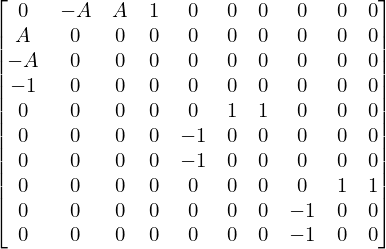

In [12]:
J_1 = sympy.Matrix([
    [0, -A, A, 1],
    [A, 0, 0, 0],
    [-A, 0, 0, 0],
    [-1, 0, 0, 0]
])

J_2 = sympy.Matrix([
    [0, 1, 1],
    [-1, 0, 0],
    [-1, 0, 0]
])

J_3 = J_2

J = sympy.BlockDiagMatrix(J_1, J_2, J_3).as_explicit()
J

In [13]:
θ_0 = sympy.Symbol("θ_0")

In [14]:
e_1 = sympy.Matrix([
    [υ],
    [-π_1],
    [-π_2],
    [-d*υ]
])

e_2 = sympy.Matrix([
    [θ_1 - θ_0],
    [1/θ_1 * α*(θ_2 - θ_1)],
    [1/θ_1 * d*υ**2/2]
])

e_3 = sympy.Matrix([
    [θ_2 - θ_0],
    [1/θ_2 * α*(θ_1 - θ_2)],
    [1/θ_2 * d*υ**2/2]
])

e = sympy.BlockMatrix([[e_1], [e_2], [e_3]]).as_explicit()

In [15]:
f = -(J @ e).simplify()
f

⎡  -A⋅π₁ + A⋅π₂ + d⋅υ  ⎤
⎢                      ⎥
⎢         -A⋅υ         ⎥
⎢                      ⎥
⎢         A⋅υ          ⎥
⎢                      ⎥
⎢          υ           ⎥
⎢                      ⎥
⎢ ⎛   2              ⎞ ⎥
⎢ ⎜d⋅υ               ⎟ ⎥
⎢-⎜──── - α⋅(θ₁ - θ₂)⎟ ⎥
⎢ ⎝ 2                ⎠ ⎥
⎢──────────────────────⎥
⎢          θ₁          ⎥
⎢                      ⎥
⎢       -θ₀ + θ₁       ⎥
⎢                      ⎥
⎢       -θ₀ + θ₁       ⎥
⎢                      ⎥
⎢ ⎛   2              ⎞ ⎥
⎢ ⎜d⋅υ               ⎟ ⎥
⎢-⎜──── + α⋅(θ₁ - θ₂)⎟ ⎥
⎢ ⎝ 2                ⎠ ⎥
⎢──────────────────────⎥
⎢          θ₂          ⎥
⎢                      ⎥
⎢       -θ₀ + θ₂       ⎥
⎢                      ⎥
⎣       -θ₀ + θ₂       ⎦

In [16]:
x

In [17]:
xdot = [-f[0], -f[4], -f[1], -f[7], -f[2]]
xdot

In [18]:
constraints = [v_1 + v_2 - A * (l - w)]

In [19]:
t_f = 0.8
dt = 10e-4
s = 2
print(f"K = {int(t_f // dt)}")

K = 800


In [20]:
class Logger:
    def __init__(self):
        self.log = []
    
    def info(self, message):
        self.log.append(message)

In [21]:
logger = Logger()
%time time, solution = gauss_legendre(x, xdot, x_0, t_f, dt, s, functionals, params, tol=1e-9, logger=logger, constraints=constraints)

CPU times: user 1.74 s, sys: 9.73 ms, total: 1.75 s
Wall time: 1.76 s


In [22]:
logger.log[0:5]

['converged after 3 steps',
 'converged after 3 steps',
 'converged after 3 steps',
 'converged after 3 steps',
 'converged after 3 steps']

In [23]:
time2, solution2 = time.copy(), solution.copy()

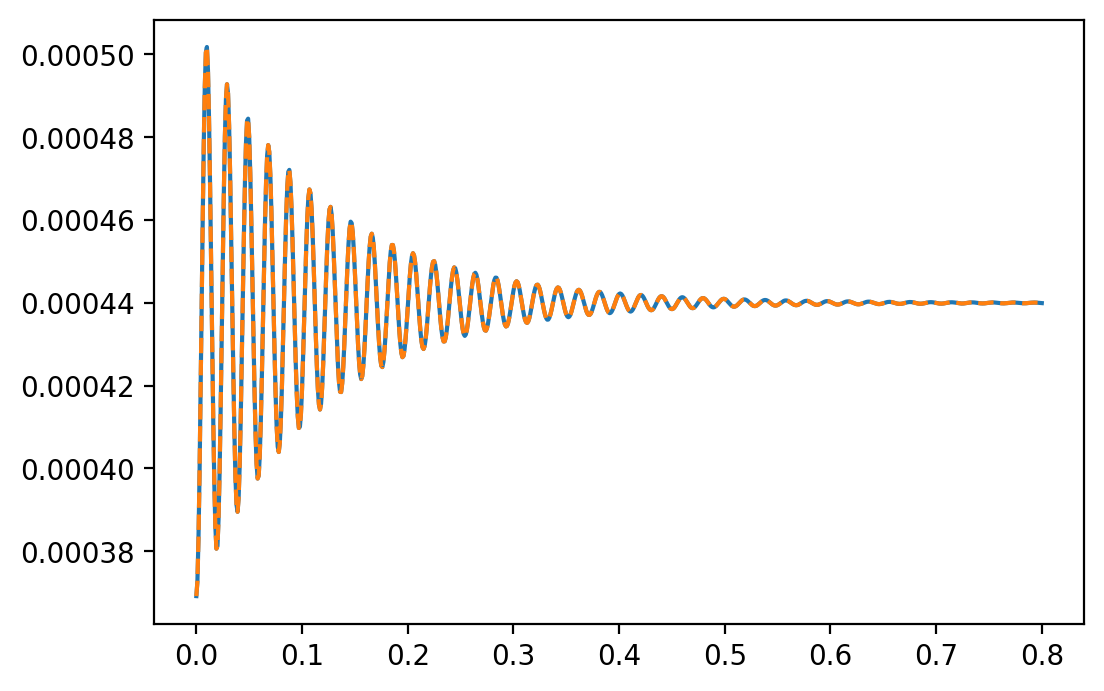

In [24]:
fig, ax = plt.subplots(dpi=200)
ax.plot(time, solution[:, 2], label="v_1");
#ax.plot(time, solution[:, 4], label="v_2");
#ax.legend();
ax.plot(time2, solution2[:, 2], '--');

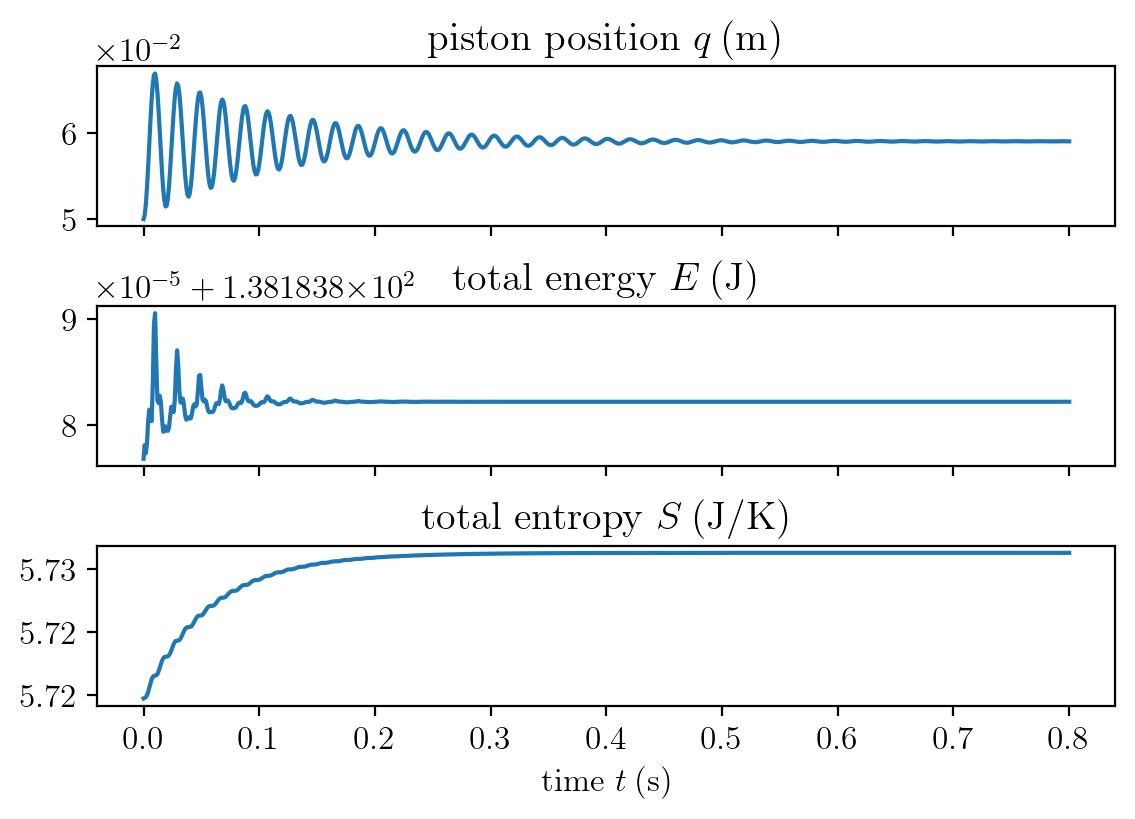

In [29]:
import matplotlib.ticker as mticker

class MathTextSciFormatter(mticker.Formatter):
    def __init__(self, fmt="%1.2e"):
        self.fmt = fmt
    def __call__(self, x, pos=None):
        s = self.fmt % x
        decimal_point = '.'
        positive_sign = '+'
        tup = s.split('e')
        significand = tup[0].rstrip(decimal_point)
        sign = tup[1][0].replace(positive_sign, '')
        exponent = tup[1][1:].lstrip('0')
        if exponent:
            exponent = '10^{%s%s}' % (sign, exponent)
        if significand and exponent:
            s =  r'%s{\times}%s' % (significand, exponent)
        else:
            s =  r'%s%s' % (significand, exponent)
        return "${}$".format(s)


fig, axes = plt.subplots(nrows=3, sharex=True, dpi=200)
fig.tight_layout(pad=1.5)

# piston position q
axes[0].set_title(r"piston position $q \: (\mathrm{m})$")
axes[0].plot(time, evaluate_functional(x, q, solution, functionals, params))
#axes[0].set_ylabel(r"$q \: (\mathrm{m})$")
axes[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axes[0].xaxis.major.formatter._useMathText = True
#axes[0].yaxis.set_major_formatter(MathTextSciFormatter("%1.2e"))

# total energy E
axes[1].set_title(r"total energy $E \: (\mathrm{J})$")
axes[1].plot(time, evaluate_functional(x, E, solution, functionals, params))
#axes[1].set_ylabel(r"$E \: (\mathrm{J})$")
axes[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#axes[1].yaxis.set_major_formatter(MathTextSciFormatter("%1.2e"))

# total entropy S
S = s_1 + s_2
axes[2].set_title(r"total entropy $S \: (\mathrm{J}/\mathrm{K})$")
axes[2].plot(time, evaluate_functional(x, S, solution, functionals, params))
axes[2].set_xlabel(r"time $t \: (\mathrm{s})$")
#axes[2].set_ylabel(r"$S \: (\mathrm{J}/\mathrm{K})$");
#axes[2].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axes[2].yaxis.set_major_formatter(MathTextSciFormatter("%1.2e"))

# Format with 2 decimal places
#plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.2e"))

# error on hidden constraint
# V = v_1 + v_2
# V_tot = A * (l - w)
# axes[3].plot(time, evaluate_functional(x, V - V_tot, solution, functionals, params))
# axes[3].set_xlabel(r"$t \: (\mathrm{s})$")
# axes[3].set_ylabel(r"$\tilde{V} \: (\mathrm{m^3})$");
# axes[3].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

font = {
    'family' : 'Calibri',
    'weight' : 'normal',
    'size'   : 12
}
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

#fig.savefig("simulation.pdf")

In [26]:
# relative error for energy conservation
energy = evaluate_functional(x, E, solution, functionals, params)
abs(energy[0] - energy[-1]) / energy[0]

In [27]:
import matplotlib
import matplotlib.animation as anim


def animate(solution, functionals, params, file):
    plt.ioff()

    r2 = 2 * params[r]
    w2 = params[w] / 2
    l2 = params[l] - w2

    cmap = matplotlib.cm.get_cmap('YlOrRd')

    fig, ax = plt.subplots(dpi=200)
    ax.set_xlim(left=0, right=params[l])
    ax.set_ylim(bottom=-params[r], top=params[r])

    q0 = params[l]/2
    vol1 = plt.Rectangle((0, -params[r]), q0-w2, r2, fc='b')
    ax.add_patch(vol1)
    pist = plt.Rectangle((q0-w2, -params[r]), params[w], r2, fc='#C84843')
    ax.add_patch(pist)
    vol2 = plt.Rectangle((q0+w2, -params[r]), l2-q0, r2, fc='g')
    ax.add_patch(vol2)

    sol_q = evaluate_functional(x, q, solution, functionals, params)
    sol_θ_1 = evaluate_functional(x, θ_1, solution, functionals, params)
    sol_θ_2 = evaluate_functional(x, θ_2, solution, functionals, params)
    
    θ_min = numpy.min([numpy.min(sol_θ_1), numpy.min(sol_θ_2)])
    θ_max = numpy.max([numpy.max(sol_θ_1), numpy.max(sol_θ_2)])
    θ_swing = θ_max - θ_min

    data = numpy.block([sol_q.reshape(-1,1), sol_θ_1.reshape(-1,1), sol_θ_2.reshape(-1,1)])

    def animate(datum):
        q, θ_1, θ_2 = datum

        l_1 = q - w2
        l_2 = l2 - q

        vol1.set_width(l_1)
        pist.set_x(l_1)
        vol2.set_x(l_1 + params[w])
        vol2.set_width(l_2)

        vol1.set_fc(cmap(0.8 * ((θ_1-θ_min) / θ_swing)))
        vol2.set_fc(cmap(0.8 * ((θ_2-θ_min) / θ_swing)))

        return (vol1, pist, vol2)

    animation = anim.FuncAnimation(fig, animate, frames=data, blit=True, repeat=False)
    animation.save(file, fps=20, extra_args=['-vcodec', 'libx264'])
    plt.close(fig)

In [28]:
%time animate(solution[:4000], functionals, params, 'piston.mp4')

CPU times: user 24.4 s, sys: 1.47 s, total: 25.9 s
Wall time: 27.2 s
